In [1]:
import numpy as np 
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
# Sources used:
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_bayesian_ridge.html
# https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard  -  Used this notebook for reducing the time spent on filling NA values as well as copying some functions
# https://heartbeat.fritz.ai/how-to-make-your-machine-learning-models-robust-to-outliers-44d404067d07 - Great article on dealing with Outliers


In [2]:
#Read input files
df_train = pd.read_csv('input/train.csv')
df_test = pd.read_csv('input/test.csv')

In [7]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [4]:
#concat train & test to get full data set
all_data = pd.concat([df_train,df_test])


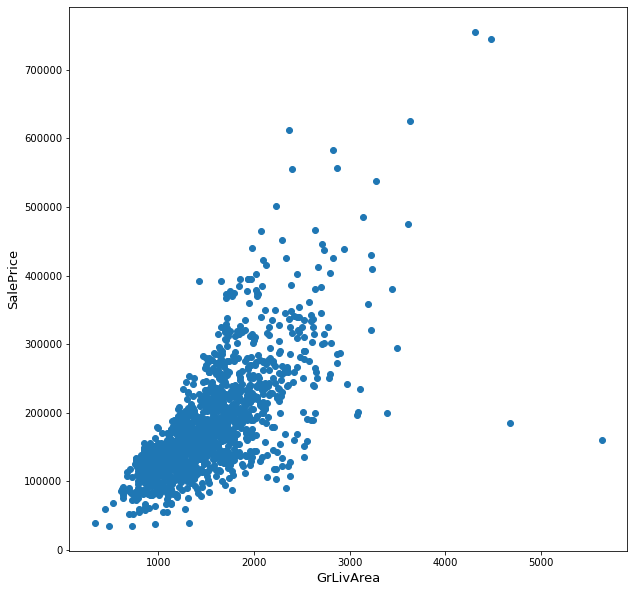

In [13]:
#Identify & Remove outliers  from training set
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x = df_train['GrLivArea'], y = df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [14]:
df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice'] < 200000)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [16]:
df_train.drop([523,1298],inplace=True)

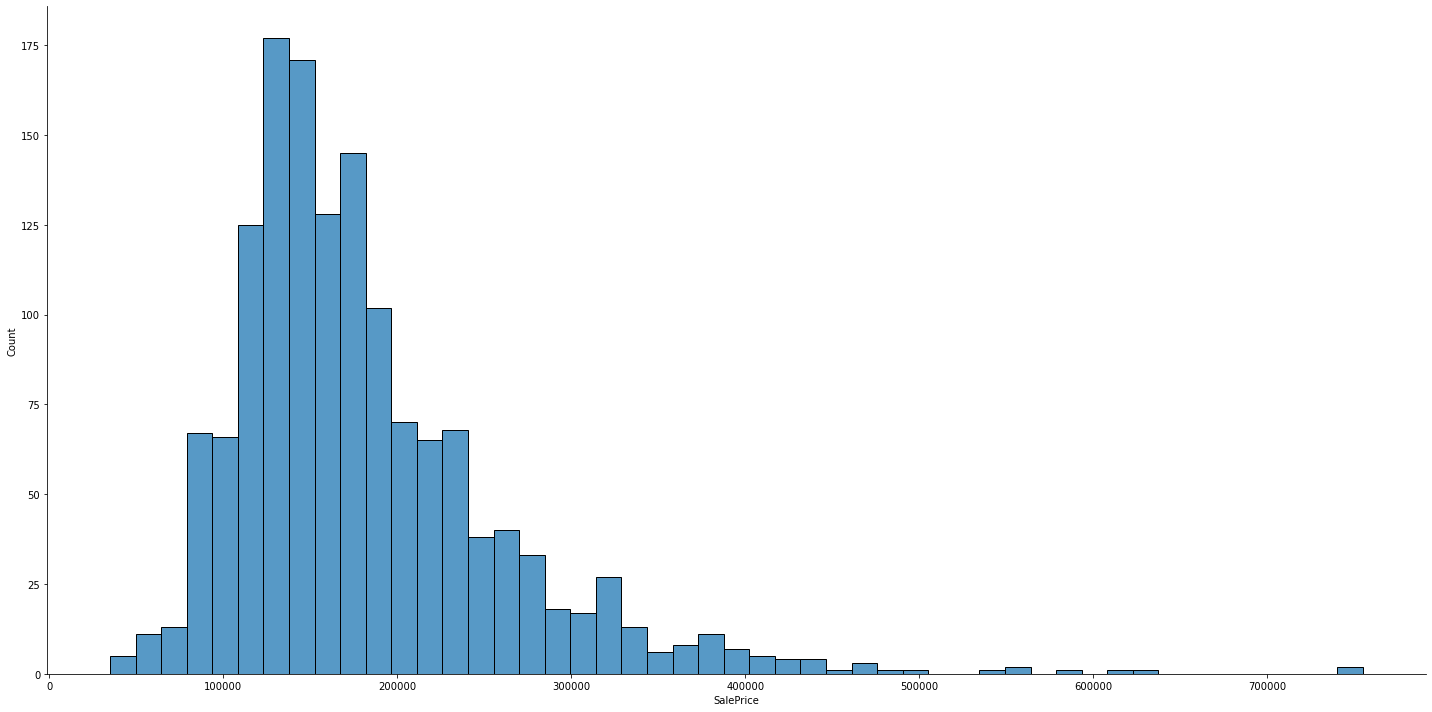

In [17]:
# Plot Distribution of Sales Price

sns.displot(df_train['SalePrice'],height=10,aspect=2)

In [18]:
# SalesPrice is right skewed, thus a log-transformation makes sense here
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

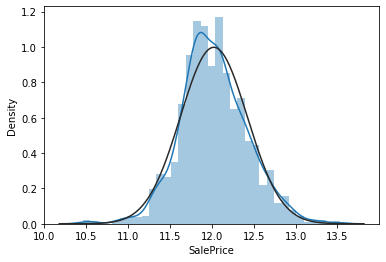

In [19]:
#Not perfect but much better
sns.distplot(df_train['SalePrice'] , fit=norm)

In [10]:
#get cols with > 80 Na values
big_na_cols = list(df_train.isna().sum()[df_train.isna().sum() > 80].index)

In [20]:
# Feature Engineering Section


In [21]:
#drop sale price
all_data.drop(columns=['SalePrice'],inplace=True)

In [32]:
all_data.reset_index(drop=True,inplace=True)

In [36]:
all_data.drop([523,1298],inplace=True)

In [72]:
nas = all_data.isna().sum()

In [73]:
nas = nas[nas != 0]

In [74]:
nas.sort_values(ascending=False)

LotFrontage    486
dtype: int64

In [40]:
# We will use the data_description.txt (referred to as docs) file to try to impute values for NAs..

In [42]:
# docs says NA means no pool
all_data['PoolQC'] = all_data['PoolQC'].fillna("None")

In [43]:
#docs says NA means no misc feature
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

In [44]:
#docs says NA means no Alley
all_data["Alley"] = all_data["Alley"].fillna("None")

In [45]:
#docs says NA means no Fence
all_data["Fence"] = all_data["Fence"].fillna("None")

In [46]:
#docs says NA means no Fireplace
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

In [79]:
#use median to fill nas
all_data['LotFrontage'] = all_data['LotFrontage'].fillna(69)

In [47]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

In [48]:
#fill with zero for numeric cols
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

In [49]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

In [50]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [51]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

In [56]:
all_data['MSZoning'] = all_data['MSZoning'].fillna('RL') 

In [57]:
#Drop this col because all values are the same except one in the training set
all_data.drop(columns=['Utilities'],inplace=True)

In [58]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [60]:
all_data['Electrical'].value_counts()

SBrkr    2669
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [61]:
all_data['Electrical'] = all_data['Electrical'].fillna('SBrkr')

In [63]:
#fill nas with most common value
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [81]:
# Nas are now all replaced or removed
all_data.isna().sum().sum()

0

In [71]:
all_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,Inside,...,0,0,None,None,None,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,FR2,...,0,0,None,None,None,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,Inside,...,0,0,None,None,None,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,Corner,...,0,0,None,None,None,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,FR2,...,0,0,None,None,None,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,None,Reg,Lvl,Inside,...,0,0,None,None,None,0,6,2006,WD,Normal
2915,2916,160,RM,21.0,1894,Pave,None,Reg,Lvl,Inside,...,0,0,None,None,None,0,4,2006,WD,Abnorml
2916,2917,20,RL,160.0,20000,Pave,None,Reg,Lvl,Inside,...,0,0,None,None,None,0,9,2006,WD,Abnorml
2917,2918,85,RL,62.0,10441,Pave,None,Reg,Lvl,Inside,...,0,0,None,MnPrv,Shed,700,7,2006,WD,Normal


In [82]:
# changing year built to age of house, by subtrating 2021 - year built
all_data['Age_of_House'] = 2021 - all_data['YearBuilt']

In [84]:
all_data.drop(columns=['YearBuilt'],inplace=True)

In [99]:
# Turn these into categorial variables
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [105]:
# Use LabelEncoder to transform cat variables that have an order set
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

In [109]:
# Fix Skewed columns
from scipy.stats import skew

In [110]:
numeric_cols = all_data.dtypes[all_data.dtypes != 'object'].index

skewed_feats = all_data[numeric_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)


MiscVal          21.939672
PoolArea         17.688664
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
LandSlope         4.973254
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
MasVnrArea        2.621719
OpenPorchSF       2.529358
WoodDeckSF        1.844792
1stFlrSF          1.257286
LotFrontage       1.232624
GrLivArea         1.068750
BsmtFinSF1        0.980645
BsmtUnfSF         0.919688
2ndFlrSF          0.861556
BsmtExposure     -1.117321
KitchenQual      -1.449814
ExterQual        -1.800062
Fence            -1.992649
ExterCond        -2.496489
BsmtCond         -2.861271
PavedDrive       -2.977741
BsmtFinType2     -3.042979
GarageQual       -3.072788
CentralAir       -3.457555
GarageCond       -3.594290
GarageYrBlt      -3.904632
Functional       -4.054126
Street          -15.494756
PoolQC          -21.217600
dtype: float64

In [115]:
#Transform cols with skew > 1
skewed_feats_to_transform = skewed_feats[abs(skewed_feats) > 1]
skewed_cols_to_transform = skewed_feats_to_transform.index

for col in skewed_cols_to_transform:
    all_data[col] = np.log1p(all_data[col])

In [116]:
# Transform categorial cols
all_data = pd.get_dummies(all_data)

In [117]:
train = all_data[all_data['Id'].isin(range(0,1461))]

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,5,4.189655,9.042040,0.693147,1,3,0.0,7,5,...,0,0,0,1,0,0,0,0,1,0
1,2,0,4.394449,9.169623,0.693147,1,3,0.0,6,8,...,0,0,0,1,0,0,0,0,1,0
2,3,5,4.234107,9.328212,0.693147,1,0,0.0,7,5,...,0,0,0,1,0,0,0,0,1,0
3,4,6,4.110874,9.164401,0.693147,1,0,0.0,7,5,...,0,0,0,1,1,0,0,0,0,0
4,5,5,4.442651,9.565284,0.693147,1,0,0.0,8,5,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,5,4.143135,8.976894,0.693147,1,3,0.0,6,5,...,0,0,0,1,0,0,0,0,1,0
1456,1457,0,4.454347,9.486152,0.693147,1,3,0.0,6,6,...,0,0,0,1,0,0,0,0,1,0
1457,1458,6,4.204693,9.109746,0.693147,1,3,0.0,7,9,...,0,0,0,1,0,0,0,0,1,0
1458,1459,0,4.234107,9.181735,0.693147,1,3,0.0,5,6,...,0,0,0,1,0,0,0,0,1,0


In [179]:
test = all_data[~all_data['Id'].isin(train['Id'])]

In [180]:
train['SalePrice'] = df_train['SalePrice']

In [181]:
train

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,1,5,4.189655,9.042040,0.693147,1,3,0.0,7,5,...,0,0,1,0,0,0,0,1,0,12.247699
1,2,0,4.394449,9.169623,0.693147,1,3,0.0,6,8,...,0,0,1,0,0,0,0,1,0,12.109016
2,3,5,4.234107,9.328212,0.693147,1,0,0.0,7,5,...,0,0,1,0,0,0,0,1,0,12.317171
3,4,6,4.110874,9.164401,0.693147,1,0,0.0,7,5,...,0,0,1,1,0,0,0,0,0,11.849405
4,5,5,4.442651,9.565284,0.693147,1,0,0.0,8,5,...,0,0,1,0,0,0,0,1,0,12.429220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,5,4.143135,8.976894,0.693147,1,3,0.0,6,5,...,0,0,1,0,0,0,0,1,0,12.072547
1456,1457,0,4.454347,9.486152,0.693147,1,3,0.0,6,6,...,0,0,1,0,0,0,0,1,0,12.254868
1457,1458,6,4.204693,9.109746,0.693147,1,3,0.0,7,9,...,0,0,1,0,0,0,0,1,0,12.493133
1458,1459,0,4.234107,9.181735,0.693147,1,3,0.0,5,6,...,0,0,1,0,0,0,0,1,0,11.864469


In [184]:
y_train = train['SalePrice']
train = train.drop(columns=['SalePrice'])

In [185]:
# train

In [186]:
#plot corr
# corrmat = train.corr()
# f,ax = plt.subplots()
# sns.heatmap(corrmat,vmax=.8,square =False,annot=True)

In [187]:
# Modeling

In [188]:
from sklearn.linear_model import Lasso,  BayesianRidge
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [189]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [190]:
lasso = Lasso()
bayridge = BayesianRidge()
model_xgb = xgb.XGBRegressor()
model_xgbrf = xgb.XGBRFRegressor()

In [191]:
# See base model scores
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1871 (0.0051)



In [192]:
score = rmsle_cv(bayridge)
print("\nbayridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


bayridge score: 0.1121 (0.0075)



In [193]:
score = rmsle_cv(model_xgb)
print("XGB Regressor score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

XGB Regressor score: 0.1372 (0.0051)



In [194]:
score = rmsle_cv(model_xgbrf)
print("XGB RF Regressor score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

XGB RF Regressor score: 0.1499 (0.0043)



In [195]:
bayridge.fit(train,y_train)

BayesianRidge()

In [196]:
preds = bayridge.predict(test)

In [197]:
preds = np.expm1(preds)

In [198]:
test['Id'].values

array([1461, 1462, 1463, ..., 2917, 2918, 2919])

In [199]:
df_submission = pd.DataFrame.from_dict({'Id':test['Id'].values,'SalePrice':preds})

In [200]:
df_submission.to_csv('submissions/submission1.csv',index=False)

In [203]:
# Top 25% submission
# Will improve in the future with increased feature engineering, testing new models, and further parameter tuning